In [43]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seem for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [44]:
import os
import random
import shutil
from zipfile import ZipFile
from google.colab import drive
import keras.utils

# Монтирование Google Диска
drive.mount('/content/drive')

# Путь к zip файлу
zip_file_path = "/content/drive/MyDrive/archive.zip"

# Создаем директорию для распаковки архива
os.makedirs("anime_gan", exist_ok=True)

# Распаковка архива
with ZipFile(zip_file_path, "r") as zipobj:
    zipobj.extractall("anime_gan")

# Путь к вашему исходному датасету
source_dir = "anime_gan/images"
# Путь к новому датасету
target_dir = "anime_gan/small_dataset"
class_dir = os.path.join(target_dir, "class1")

# Создаем целевую директорию и фиктивную директорию класса, если они не существуют
os.makedirs(class_dir, exist_ok=True)

# Получаем список всех файлов в исходной директории
all_files = os.listdir(source_dir)

# Перемешиваем файлы и выбираем первые 5000
random.shuffle(all_files)
selected_files = all_files[:5000]

# Копируем выбранные файлы в новую директорию класса
for file_name in selected_files:
    source_file = os.path.join(source_dir, file_name)
    target_file = os.path.join(class_dir, file_name)
    shutil.copy(source_file, target_file)

print(f"Скопировано {len(selected_files)} файлов в {class_dir}")

# Конфигурация для обучения модели
dataroot = target_dir

# Number of workers for dataloader
workers = 4

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 20

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Скопировано 5000 файлов в anime_gan/small_dataset/class1


In [42]:
# Удалить папку и все ее содержимое
!rm -r /content/anime_gan/small_dataset

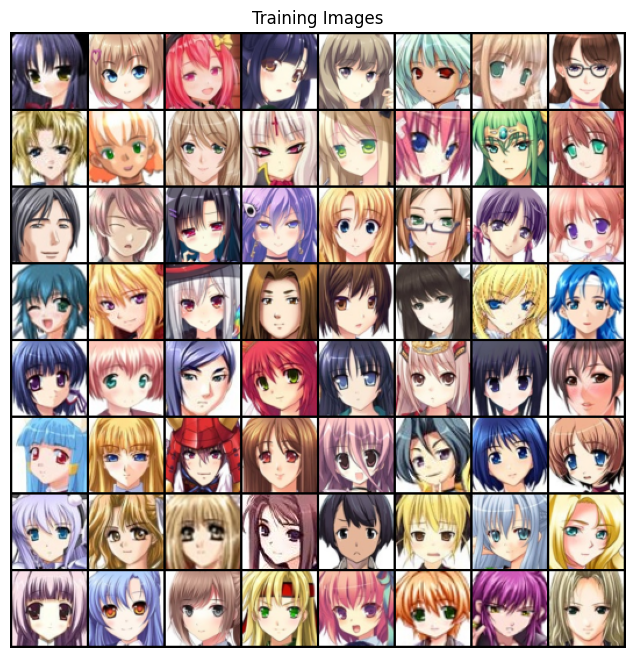

In [45]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [22]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [23]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [24]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [46]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [47]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [48]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [49]:
import os
import torch
import torchvision.utils as vutils
import matplotlib.pyplot as plt
from tqdm import tqdm

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

def gan_monitor(generator, output_dir, epoch, num_img=10, latent_dim=100):
    # Generate some sample images
    noise = torch.randn(num_img, latent_dim, 1, 1, device=device)
    with torch.no_grad():
        fake_images = generator(noise).detach().cpu()
    # Save or display the images
    grid = vutils.make_grid(fake_images, padding=2, normalize=True)
    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(grid, (1,2,0)))
    plt.axis("off")
    os.makedirs(output_dir, exist_ok=True)  # Ensure the directory exists
    plt.savefig(f"{output_dir}/epoch_{epoch}.png")
    plt.close()

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # Initialize tqdm to track progress
    data_iterator = tqdm(enumerate(dataloader, 0), total=len(dataloader))

    # Initialize loss variables for the epoch
    running_loss_D = 0.0
    running_loss_G = 0.0

    # For each batch in the dataloader
    for i, data in data_iterator:

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device).float()  # Convert to float
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label).float()  # Convert to float
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label).float()  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 10 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        iters += 1

    # Print average loss for the epoch
    avg_loss_D = running_loss_D / len(dataloader)
    avg_loss_G = running_loss_G / len(dataloader)
    print(f"Avg Loss D: {avg_loss_D:.4f}, Avg Loss G: {avg_loss_G:.4f}")

    # Call GANMonitor after each epoch
    gan_monitor(netG, output_dir="generated_images", epoch=epoch)

    # Save model weights
    os.makedirs("saved_weights", exist_ok=True)
    torch.save(netG.state_dict(), f"saved_weights/netG_epoch_{epoch}.pth")
    torch.save(netD.state_dict(), f"saved_weights/netD_epoch_{epoch}.pth")

    # Save entire model
    os.makedirs("saved_models", exist_ok=True)
    torch.save(netG, f"saved_models/netG_epoch_{epoch}.pt")
    torch.save(netD, f"saved_models/netD_epoch_{epoch}.pt")

print("Training Loop Completed")


Starting Training Loop...


  2%|▎         | 1/40 [00:14<09:42, 14.95s/it]

[0/20][0/40]	Loss_D: 1.5209	Loss_G: 15.0793	D(x): 0.7206	D(G(z)): 0.6425 / 0.0000


 28%|██▊       | 11/40 [02:03<05:11, 10.72s/it]

[0/20][10/40]	Loss_D: 0.3103	Loss_G: 8.1929	D(x): 0.8417	D(G(z)): 0.0833 / 0.0007


 52%|█████▎    | 21/40 [03:41<02:58,  9.42s/it]

[0/20][20/40]	Loss_D: 1.8646	Loss_G: 11.4225	D(x): 0.9578	D(G(z)): 0.7019 / 0.0001


 78%|███████▊  | 31/40 [05:18<01:24,  9.41s/it]

[0/20][30/40]	Loss_D: 0.4997	Loss_G: 5.7874	D(x): 0.7366	D(G(z)): 0.0913 / 0.0069


100%|██████████| 40/40 [06:39<00:00,  9.98s/it]


Avg Loss D: 0.0000, Avg Loss G: 0.0000


  2%|▎         | 1/40 [00:12<08:21, 12.86s/it]

[1/20][0/40]	Loss_D: 1.6455	Loss_G: 9.0316	D(x): 0.3866	D(G(z)): 0.0011 / 0.0006


 28%|██▊       | 11/40 [01:51<05:03, 10.45s/it]

[1/20][10/40]	Loss_D: 0.3042	Loss_G: 5.7610	D(x): 0.8127	D(G(z)): 0.0280 / 0.0096


 52%|█████▎    | 21/40 [03:32<03:12, 10.14s/it]

[1/20][20/40]	Loss_D: 1.0743	Loss_G: 11.9880	D(x): 0.4932	D(G(z)): 0.0011 / 0.0000


 78%|███████▊  | 31/40 [05:10<01:30, 10.03s/it]

[1/20][30/40]	Loss_D: 0.4775	Loss_G: 5.4360	D(x): 0.8241	D(G(z)): 0.1678 / 0.0134


100%|██████████| 40/40 [06:31<00:00,  9.78s/it]


Avg Loss D: 0.0000, Avg Loss G: 0.0000


  2%|▎         | 1/40 [00:11<07:22, 11.36s/it]

[2/20][0/40]	Loss_D: 0.4117	Loss_G: 7.0570	D(x): 0.8931	D(G(z)): 0.2103 / 0.0025


 28%|██▊       | 11/40 [01:50<04:30,  9.32s/it]

[2/20][10/40]	Loss_D: 0.2884	Loss_G: 7.3546	D(x): 0.8851	D(G(z)): 0.0401 / 0.0025


 52%|█████▎    | 21/40 [03:34<03:09,  9.99s/it]

[2/20][20/40]	Loss_D: 0.6964	Loss_G: 4.6658	D(x): 0.6818	D(G(z)): 0.0414 / 0.0252


 78%|███████▊  | 31/40 [05:09<01:28,  9.78s/it]

[2/20][30/40]	Loss_D: 1.0283	Loss_G: 2.4525	D(x): 0.5083	D(G(z)): 0.0460 / 0.1625


100%|██████████| 40/40 [06:32<00:00,  9.81s/it]


Avg Loss D: 0.0000, Avg Loss G: 0.0000


  2%|▎         | 1/40 [00:09<06:19,  9.74s/it]

[3/20][0/40]	Loss_D: 0.5852	Loss_G: 3.7676	D(x): 0.7146	D(G(z)): 0.1013 / 0.0518


 28%|██▊       | 11/40 [01:47<04:36,  9.53s/it]

[3/20][10/40]	Loss_D: 0.7315	Loss_G: 6.2851	D(x): 0.9036	D(G(z)): 0.3955 / 0.0042


 52%|█████▎    | 21/40 [03:30<03:11, 10.08s/it]

[3/20][20/40]	Loss_D: 0.6166	Loss_G: 4.9076	D(x): 0.8343	D(G(z)): 0.2571 / 0.0151


 78%|███████▊  | 31/40 [05:08<01:31, 10.16s/it]

[3/20][30/40]	Loss_D: 0.6972	Loss_G: 3.2121	D(x): 0.6012	D(G(z)): 0.0458 / 0.0594


100%|██████████| 40/40 [06:30<00:00,  9.77s/it]


Avg Loss D: 0.0000, Avg Loss G: 0.0000


  2%|▎         | 1/40 [00:11<07:25, 11.42s/it]

[4/20][0/40]	Loss_D: 0.6525	Loss_G: 5.8565	D(x): 0.8653	D(G(z)): 0.3070 / 0.0084


 28%|██▊       | 11/40 [01:49<04:47,  9.91s/it]

[4/20][10/40]	Loss_D: 0.6835	Loss_G: 4.7961	D(x): 0.5955	D(G(z)): 0.0272 / 0.0155


 52%|█████▎    | 21/40 [03:30<03:12, 10.14s/it]

[4/20][20/40]	Loss_D: 0.8792	Loss_G: 7.5271	D(x): 0.8892	D(G(z)): 0.4587 / 0.0018


 78%|███████▊  | 31/40 [05:10<01:36, 10.73s/it]

[4/20][30/40]	Loss_D: 1.4008	Loss_G: 0.7491	D(x): 0.3666	D(G(z)): 0.0481 / 0.5334


100%|██████████| 40/40 [06:30<00:00,  9.76s/it]


Avg Loss D: 0.0000, Avg Loss G: 0.0000


  2%|▎         | 1/40 [00:12<08:21, 12.85s/it]

[5/20][0/40]	Loss_D: 2.6428	Loss_G: 5.2527	D(x): 0.1781	D(G(z)): 0.0042 / 0.0115


 28%|██▊       | 11/40 [01:52<05:10, 10.71s/it]

[5/20][10/40]	Loss_D: 0.4468	Loss_G: 3.3048	D(x): 0.8318	D(G(z)): 0.1838 / 0.0632


 52%|█████▎    | 21/40 [03:32<03:05,  9.76s/it]

[5/20][20/40]	Loss_D: 0.8772	Loss_G: 3.0308	D(x): 0.5745	D(G(z)): 0.0638 / 0.0642


 78%|███████▊  | 31/40 [05:12<01:30, 10.11s/it]

[5/20][30/40]	Loss_D: 0.9569	Loss_G: 7.2291	D(x): 0.9568	D(G(z)): 0.5276 / 0.0013


100%|██████████| 40/40 [06:31<00:00,  9.79s/it]


Avg Loss D: 0.0000, Avg Loss G: 0.0000


  2%|▎         | 1/40 [00:12<08:18, 12.78s/it]

[6/20][0/40]	Loss_D: 1.0271	Loss_G: 6.7225	D(x): 0.8328	D(G(z)): 0.4507 / 0.0019


 28%|██▊       | 11/40 [01:51<05:02, 10.44s/it]

[6/20][10/40]	Loss_D: 0.3707	Loss_G: 3.6346	D(x): 0.7850	D(G(z)): 0.0473 / 0.0372


 52%|█████▎    | 21/40 [03:30<03:02,  9.63s/it]

[6/20][20/40]	Loss_D: 0.5075	Loss_G: 5.3152	D(x): 0.9335	D(G(z)): 0.3210 / 0.0080


 78%|███████▊  | 31/40 [05:13<01:39, 11.09s/it]

[6/20][30/40]	Loss_D: 1.2568	Loss_G: 7.4174	D(x): 0.7535	D(G(z)): 0.5496 / 0.0015


100%|██████████| 40/40 [06:32<00:00,  9.82s/it]


Avg Loss D: 0.0000, Avg Loss G: 0.0000


  2%|▎         | 1/40 [00:09<05:56,  9.14s/it]

[7/20][0/40]	Loss_D: 0.9477	Loss_G: 2.6767	D(x): 0.5100	D(G(z)): 0.0404 / 0.0924


 28%|██▊       | 11/40 [01:52<05:18, 10.97s/it]

[7/20][10/40]	Loss_D: 0.7356	Loss_G: 5.2813	D(x): 0.5749	D(G(z)): 0.0145 / 0.0081


 52%|█████▎    | 21/40 [03:27<03:03,  9.66s/it]

[7/20][20/40]	Loss_D: 0.5842	Loss_G: 6.3550	D(x): 0.9341	D(G(z)): 0.3718 / 0.0027


 78%|███████▊  | 31/40 [05:07<01:29,  9.97s/it]

[7/20][30/40]	Loss_D: 0.7616	Loss_G: 8.6676	D(x): 0.8562	D(G(z)): 0.3673 / 0.0004


100%|██████████| 40/40 [06:26<00:00,  9.65s/it]


Avg Loss D: 0.0000, Avg Loss G: 0.0000


  2%|▎         | 1/40 [00:12<08:06, 12.46s/it]

[8/20][0/40]	Loss_D: 0.3404	Loss_G: 6.4390	D(x): 0.8013	D(G(z)): 0.0342 / 0.0047


 28%|██▊       | 11/40 [01:54<04:56, 10.23s/it]

[8/20][10/40]	Loss_D: 2.3550	Loss_G: 9.7944	D(x): 0.9645	D(G(z)): 0.8459 / 0.0002


 52%|█████▎    | 21/40 [03:32<03:01,  9.56s/it]

[8/20][20/40]	Loss_D: 0.3616	Loss_G: 4.6179	D(x): 0.8409	D(G(z)): 0.1339 / 0.0140


 78%|███████▊  | 31/40 [05:12<01:27,  9.75s/it]

[8/20][30/40]	Loss_D: 0.5312	Loss_G: 5.9345	D(x): 0.8647	D(G(z)): 0.2583 / 0.0052


100%|██████████| 40/40 [06:29<00:00,  9.74s/it]


Avg Loss D: 0.0000, Avg Loss G: 0.0000


  2%|▎         | 1/40 [00:13<08:30, 13.10s/it]

[9/20][0/40]	Loss_D: 0.6276	Loss_G: 4.9515	D(x): 0.7793	D(G(z)): 0.1687 / 0.0128


 28%|██▊       | 11/40 [01:54<04:57, 10.26s/it]

[9/20][10/40]	Loss_D: 0.5375	Loss_G: 4.7648	D(x): 0.7320	D(G(z)): 0.0946 / 0.0123


 52%|█████▎    | 21/40 [03:30<03:07,  9.85s/it]

[9/20][20/40]	Loss_D: 0.7968	Loss_G: 4.3952	D(x): 0.7757	D(G(z)): 0.3157 / 0.0188


 78%|███████▊  | 31/40 [05:10<01:30, 10.04s/it]

[9/20][30/40]	Loss_D: 0.5219	Loss_G: 5.0277	D(x): 0.7756	D(G(z)): 0.1674 / 0.0101


100%|██████████| 40/40 [06:26<00:00,  9.67s/it]


Avg Loss D: 0.0000, Avg Loss G: 0.0000


  2%|▎         | 1/40 [00:09<06:20,  9.77s/it]

[10/20][0/40]	Loss_D: 1.1299	Loss_G: 1.2633	D(x): 0.5021	D(G(z)): 0.0872 / 0.3591


 28%|██▊       | 11/40 [01:50<04:37,  9.57s/it]

[10/20][10/40]	Loss_D: 1.0404	Loss_G: 6.4179	D(x): 0.7444	D(G(z)): 0.4309 / 0.0030


 52%|█████▎    | 21/40 [03:26<02:58,  9.38s/it]

[10/20][20/40]	Loss_D: 0.6270	Loss_G: 5.3558	D(x): 0.8611	D(G(z)): 0.3092 / 0.0081


 78%|███████▊  | 31/40 [05:07<01:26,  9.66s/it]

[10/20][30/40]	Loss_D: 0.5899	Loss_G: 5.7038	D(x): 0.8299	D(G(z)): 0.2696 / 0.0068


100%|██████████| 40/40 [06:25<00:00,  9.64s/it]


Avg Loss D: 0.0000, Avg Loss G: 0.0000


  2%|▎         | 1/40 [00:12<08:17, 12.76s/it]

[11/20][0/40]	Loss_D: 4.1126	Loss_G: 4.6810	D(x): 0.0612	D(G(z)): 0.0006 / 0.0378


 28%|██▊       | 11/40 [01:58<05:10, 10.70s/it]

[11/20][10/40]	Loss_D: 0.8269	Loss_G: 5.0622	D(x): 0.8175	D(G(z)): 0.4056 / 0.0099


 52%|█████▎    | 21/40 [03:40<03:30, 11.10s/it]

[11/20][20/40]	Loss_D: 0.5826	Loss_G: 4.9265	D(x): 0.6358	D(G(z)): 0.0179 / 0.0129


 78%|███████▊  | 31/40 [05:18<01:28,  9.81s/it]

[11/20][30/40]	Loss_D: 0.5262	Loss_G: 4.2128	D(x): 0.7202	D(G(z)): 0.0802 / 0.0208


100%|██████████| 40/40 [06:40<00:00, 10.02s/it]


Avg Loss D: 0.0000, Avg Loss G: 0.0000


  2%|▎         | 1/40 [00:13<08:39, 13.33s/it]

[12/20][0/40]	Loss_D: 0.8815	Loss_G: 5.6974	D(x): 0.5654	D(G(z)): 0.0156 / 0.0228


 28%|██▊       | 11/40 [01:52<04:51, 10.05s/it]

[12/20][10/40]	Loss_D: 0.9867	Loss_G: 6.7656	D(x): 0.8432	D(G(z)): 0.4696 / 0.0033


 52%|█████▎    | 21/40 [03:35<03:14, 10.25s/it]

[12/20][20/40]	Loss_D: 0.9910	Loss_G: 6.4720	D(x): 0.7900	D(G(z)): 0.4429 / 0.0030


 78%|███████▊  | 31/40 [05:21<01:30, 10.01s/it]

[12/20][30/40]	Loss_D: 0.8720	Loss_G: 5.8729	D(x): 0.8670	D(G(z)): 0.4337 / 0.0059


100%|██████████| 40/40 [06:51<00:00, 10.29s/it]


Avg Loss D: 0.0000, Avg Loss G: 0.0000


  2%|▎         | 1/40 [00:09<06:09,  9.47s/it]

[13/20][0/40]	Loss_D: 0.6960	Loss_G: 7.0909	D(x): 0.8528	D(G(z)): 0.3458 / 0.0016


 28%|██▊       | 11/40 [01:54<04:57, 10.25s/it]

[13/20][10/40]	Loss_D: 0.3304	Loss_G: 3.2354	D(x): 0.8189	D(G(z)): 0.0736 / 0.0617


 52%|█████▎    | 21/40 [03:42<03:17, 10.40s/it]

[13/20][20/40]	Loss_D: 0.5239	Loss_G: 4.3744	D(x): 0.7389	D(G(z)): 0.1046 / 0.0216


 78%|███████▊  | 31/40 [05:34<01:43, 11.47s/it]

[13/20][30/40]	Loss_D: 1.0950	Loss_G: 9.7659	D(x): 0.9019	D(G(z)): 0.5666 / 0.0003


100%|██████████| 40/40 [06:54<00:00, 10.37s/it]


Avg Loss D: 0.0000, Avg Loss G: 0.0000


  2%|▎         | 1/40 [00:09<06:01,  9.28s/it]

[14/20][0/40]	Loss_D: 0.5372	Loss_G: 5.5051	D(x): 0.7709	D(G(z)): 0.1657 / 0.0061


 28%|██▊       | 11/40 [01:51<04:37,  9.58s/it]

[14/20][10/40]	Loss_D: 0.4788	Loss_G: 4.8326	D(x): 0.7828	D(G(z)): 0.1320 / 0.0153


 52%|█████▎    | 21/40 [03:27<02:56,  9.28s/it]

[14/20][20/40]	Loss_D: 0.7897	Loss_G: 7.3682	D(x): 0.8416	D(G(z)): 0.3871 / 0.0024


 78%|███████▊  | 31/40 [05:08<01:25,  9.45s/it]

[14/20][30/40]	Loss_D: 1.1039	Loss_G: 7.3898	D(x): 0.9206	D(G(z)): 0.5526 / 0.0017


100%|██████████| 40/40 [06:26<00:00,  9.65s/it]


Avg Loss D: 0.0000, Avg Loss G: 0.0000


  2%|▎         | 1/40 [00:15<10:10, 15.65s/it]

[15/20][0/40]	Loss_D: 0.7775	Loss_G: 6.1275	D(x): 0.8667	D(G(z)): 0.3916 / 0.0042


 28%|██▊       | 11/40 [01:55<04:40,  9.67s/it]

[15/20][10/40]	Loss_D: 1.0790	Loss_G: 3.1463	D(x): 0.4939	D(G(z)): 0.0276 / 0.0647


 52%|█████▎    | 21/40 [03:39<03:12, 10.11s/it]

[15/20][20/40]	Loss_D: 1.2428	Loss_G: 8.9235	D(x): 0.8789	D(G(z)): 0.6114 / 0.0003


 78%|███████▊  | 31/40 [05:17<01:27,  9.67s/it]

[15/20][30/40]	Loss_D: 0.5125	Loss_G: 5.5196	D(x): 0.7327	D(G(z)): 0.0718 / 0.0092


100%|██████████| 40/40 [06:38<00:00,  9.97s/it]


Avg Loss D: 0.0000, Avg Loss G: 0.0000


  2%|▎         | 1/40 [00:12<07:56, 12.23s/it]

[16/20][0/40]	Loss_D: 0.7537	Loss_G: 4.8243	D(x): 0.6699	D(G(z)): 0.1529 / 0.0173


 28%|██▊       | 11/40 [01:50<04:33,  9.44s/it]

[16/20][10/40]	Loss_D: 0.7806	Loss_G: 3.7672	D(x): 0.5902	D(G(z)): 0.0423 / 0.0457


 52%|█████▎    | 21/40 [03:33<03:05,  9.75s/it]

[16/20][20/40]	Loss_D: 1.5832	Loss_G: 9.4981	D(x): 0.9525	D(G(z)): 0.7145 / 0.0002


 78%|███████▊  | 31/40 [05:14<01:30, 10.03s/it]

[16/20][30/40]	Loss_D: 0.6995	Loss_G: 5.9169	D(x): 0.8084	D(G(z)): 0.3068 / 0.0053


100%|██████████| 40/40 [06:34<00:00,  9.85s/it]


Avg Loss D: 0.0000, Avg Loss G: 0.0000


  2%|▎         | 1/40 [00:11<07:42, 11.86s/it]

[17/20][0/40]	Loss_D: 0.9987	Loss_G: 6.3829	D(x): 0.8562	D(G(z)): 0.4974 / 0.0030


 28%|██▊       | 11/40 [01:53<04:49,  9.98s/it]

[17/20][10/40]	Loss_D: 0.7682	Loss_G: 4.4141	D(x): 0.7028	D(G(z)): 0.2137 / 0.0200


 52%|█████▎    | 21/40 [03:30<02:58,  9.41s/it]

[17/20][20/40]	Loss_D: 0.6230	Loss_G: 4.6636	D(x): 0.6642	D(G(z)): 0.0562 / 0.0179


 78%|███████▊  | 31/40 [05:10<01:25,  9.49s/it]

[17/20][30/40]	Loss_D: 0.7759	Loss_G: 4.6653	D(x): 0.6959	D(G(z)): 0.2221 / 0.0166


100%|██████████| 40/40 [06:27<00:00,  9.70s/it]


Avg Loss D: 0.0000, Avg Loss G: 0.0000


  2%|▎         | 1/40 [00:14<09:34, 14.72s/it]

[18/20][0/40]	Loss_D: 0.5506	Loss_G: 2.3407	D(x): 0.7450	D(G(z)): 0.1100 / 0.1473


 28%|██▊       | 11/40 [01:54<04:38,  9.59s/it]

[18/20][10/40]	Loss_D: 0.7141	Loss_G: 3.8025	D(x): 0.6894	D(G(z)): 0.1631 / 0.0313


 52%|█████▎    | 21/40 [03:35<03:09,  9.98s/it]

[18/20][20/40]	Loss_D: 0.9108	Loss_G: 3.9483	D(x): 0.5579	D(G(z)): 0.0263 / 0.0338


 78%|███████▊  | 31/40 [05:12<01:25,  9.50s/it]

[18/20][30/40]	Loss_D: 1.3308	Loss_G: 10.1436	D(x): 0.9267	D(G(z)): 0.6668 / 0.0001


100%|██████████| 40/40 [06:37<00:00,  9.93s/it]


Avg Loss D: 0.0000, Avg Loss G: 0.0000


  2%|▎         | 1/40 [00:12<07:56, 12.23s/it]

[19/20][0/40]	Loss_D: 0.9547	Loss_G: 3.9433	D(x): 0.5277	D(G(z)): 0.0215 / 0.0372


 28%|██▊       | 11/40 [02:02<05:45, 11.90s/it]

[19/20][10/40]	Loss_D: 0.5763	Loss_G: 3.1851	D(x): 0.6643	D(G(z)): 0.0194 / 0.0802


 52%|█████▎    | 21/40 [03:43<03:18, 10.42s/it]

[19/20][20/40]	Loss_D: 0.7865	Loss_G: 6.4521	D(x): 0.8044	D(G(z)): 0.3616 / 0.0026


 78%|███████▊  | 31/40 [05:28<01:34, 10.47s/it]

[19/20][30/40]	Loss_D: 0.5689	Loss_G: 3.3038	D(x): 0.7395	D(G(z)): 0.1022 / 0.0615


100%|██████████| 40/40 [06:46<00:00, 10.17s/it]


Avg Loss D: 0.0000, Avg Loss G: 0.0000
Training Loop Completed


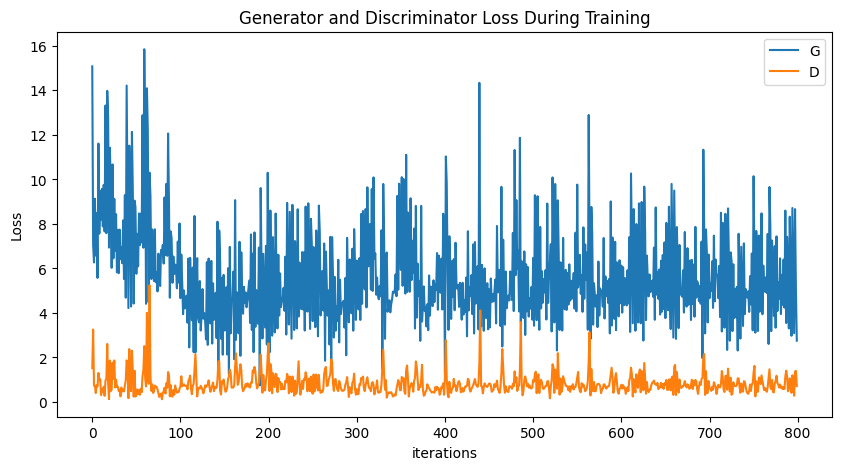

In [50]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()